In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from scipy.optimize import curve_fit
from IPython.display import display, Latex
from tqdm import tqdm

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 

### Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

# Code

## 1) Looking at the data

In [2]:
data = np.load('../solutions/transient.npy')
data.shape

(100, 3)

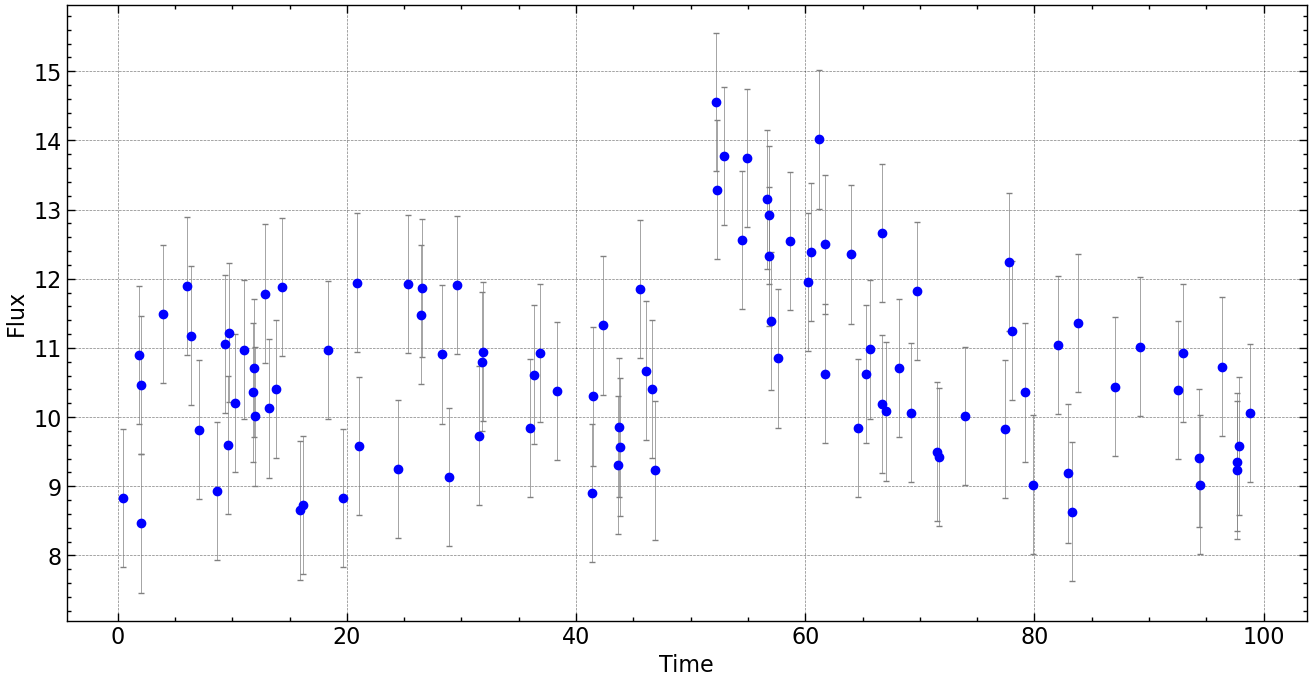

In [3]:
fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, lw=0.5)
plt.xlabel('Time')
plt.ylabel('Flux');

In [4]:
print(f'y_err = {data[:,2]}')

y_err = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


The uncertainties are homoschedastic.

## 2) Defining the model

We want to describe the data according to the following models:

$f_{burst}(t \,|\, b, A, \alpha, t_0) = 
\begin{cases}
      b & for \:\: t < t_0 \\
      b + Ae^{-\alpha(t-t_0)} & for \:\: t \geq t_0
\end{cases}$

In [5]:
def model_burst(x, b, A, alpha, t0):
    return np.piecewise(x, [x < t0, x >= t0], [lambda x: b, lambda x: b + A*np.exp(-alpha*(x-t0))])

Let's try to fit this model to the data:

b = 10.29 , A = 5.50,  alpha = 0.12 , t0 = 49.08


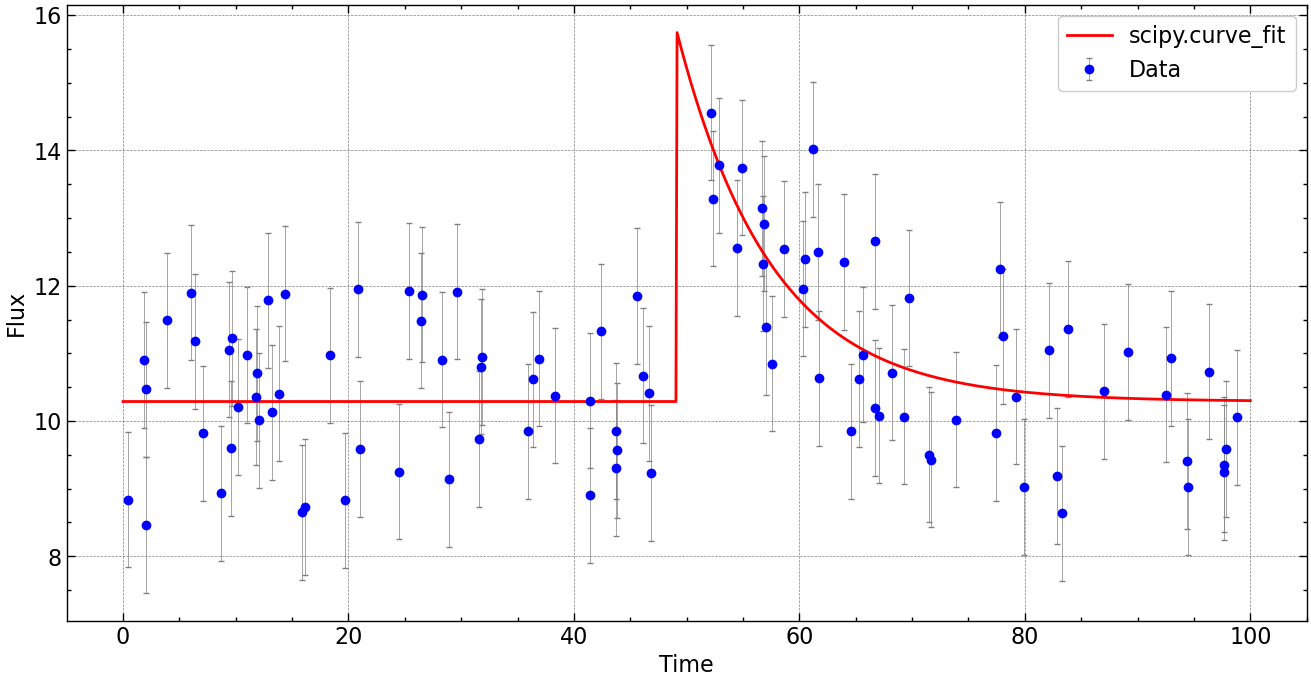

In [6]:
popt, pcov = curve_fit(model_burst, data[:,0], data[:,1], sigma=data[:,2], p0=(10, 4, 0.05, 50), absolute_sigma=True)
print(f'b = {popt[0]:.2f} , A = {popt[1]:.2f},  alpha = {popt[2]:.2f} , t0 = {popt[3]:.2f}')

fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, lw=0.5, label='Data')
x_dense = np.linspace(0, 100, 1000)
plt.plot(x_dense, model_burst(x_dense, popt[0], popt[1], popt[2], popt[3]), color='red', label='scipy.curve_fit')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend();

## 3.1) Computing the log-likelihood

Let's assume a gaussian likelihood. Since we have homoschedastic uncertainties, then we can compute it as follows:

$$L(b, A, \alpha, t_0 \,|\, \{t_i\}, \{y_i\}, \sigma) = \prod_{i=1}^{N} \dfrac{1}{\sigma \sqrt{2\pi}} \, exp\left\{-\dfrac{[y_i - f(t_i \,|\, b, A, \alpha, t_0)]^2}{2\sigma^2}\right\}$$

$$\ln\left[L(b, A, \alpha, t_0 \,|\, \{t_i\}, \{y_i\}, \sigma)\right] = -N\ln\left({ \sigma \sqrt{2\pi}}\right) - \sum_{i=1}^{N} \dfrac{[y_i - f(t_i \,|\, b, A, \alpha, t_0)]^2}{2\sigma^2}$$

In [7]:
def LogLikelihood(params, data_x, data_y, data_yerr, model=model_burst):
    model_y = model(data_x, params[0], params[1], params[2], params[3])
    #return -len(data_x)*np.log(data_yerr[0]*np.sqrt(2*np.pi)) - np.sum(0.5*np.square((data_y - model_y)/data_yerr))
    return - np.sum(0.5*np.square((data_y - model_y)/data_yerr))

LogLikelihood(popt, data[:,0], data[:,1], data[:,2])

-48.75225893896217

<font color='red'>We care about the odds ratio, which is a ratio of two evidences, and therefore we can neglect to correctly normalize the likelihood.</font>

## 3.2) Computing the prior

$b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

<font color='red'>I had to resctrict the parameter domain in order to limit the warning messages and make dynesty actually work.</font>

In [8]:
b_min = 5
b_max = 15
A_min = 0
A_max = 20
alpha_min = np.exp(-5)
alpha_max = np.exp(5)
t0_min = 40
t0_max = 60

def ptform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)` to the parameters of interest."""

    theta = np.array(u)

    theta[0] = scipy.stats.uniform(loc=b_min, scale=b_max-b_min).ppf(u[0])
    theta[1] = scipy.stats.uniform(loc=A_min, scale=A_max-A_min).ppf(u[1])
    theta[2] = scipy.stats.loguniform.ppf(u[2], alpha_min, alpha_max)
    theta[3] = scipy.stats.uniform(loc=t0_min, scale=t0_max-t0_min).ppf(u[3])

    return theta

## 4) Nested sampling with `dynesty`

In [9]:
ndim = 4
sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim, 
                                logl_args=[data[:,0], data[:,1], data[:,2], model_burst],
                                nlive=1000)
sampler.run_nested()
results = sampler.results

10552it [02:11, 80.17it/s, +1000 | bound: 33 | nc: 1 | ncall: 86378 | eff(%): 13.530 | loglstar:   -inf < -48.771 <    inf | logz: -59.216 +/-  0.105 | dlogz:  0.001 >  1.009]


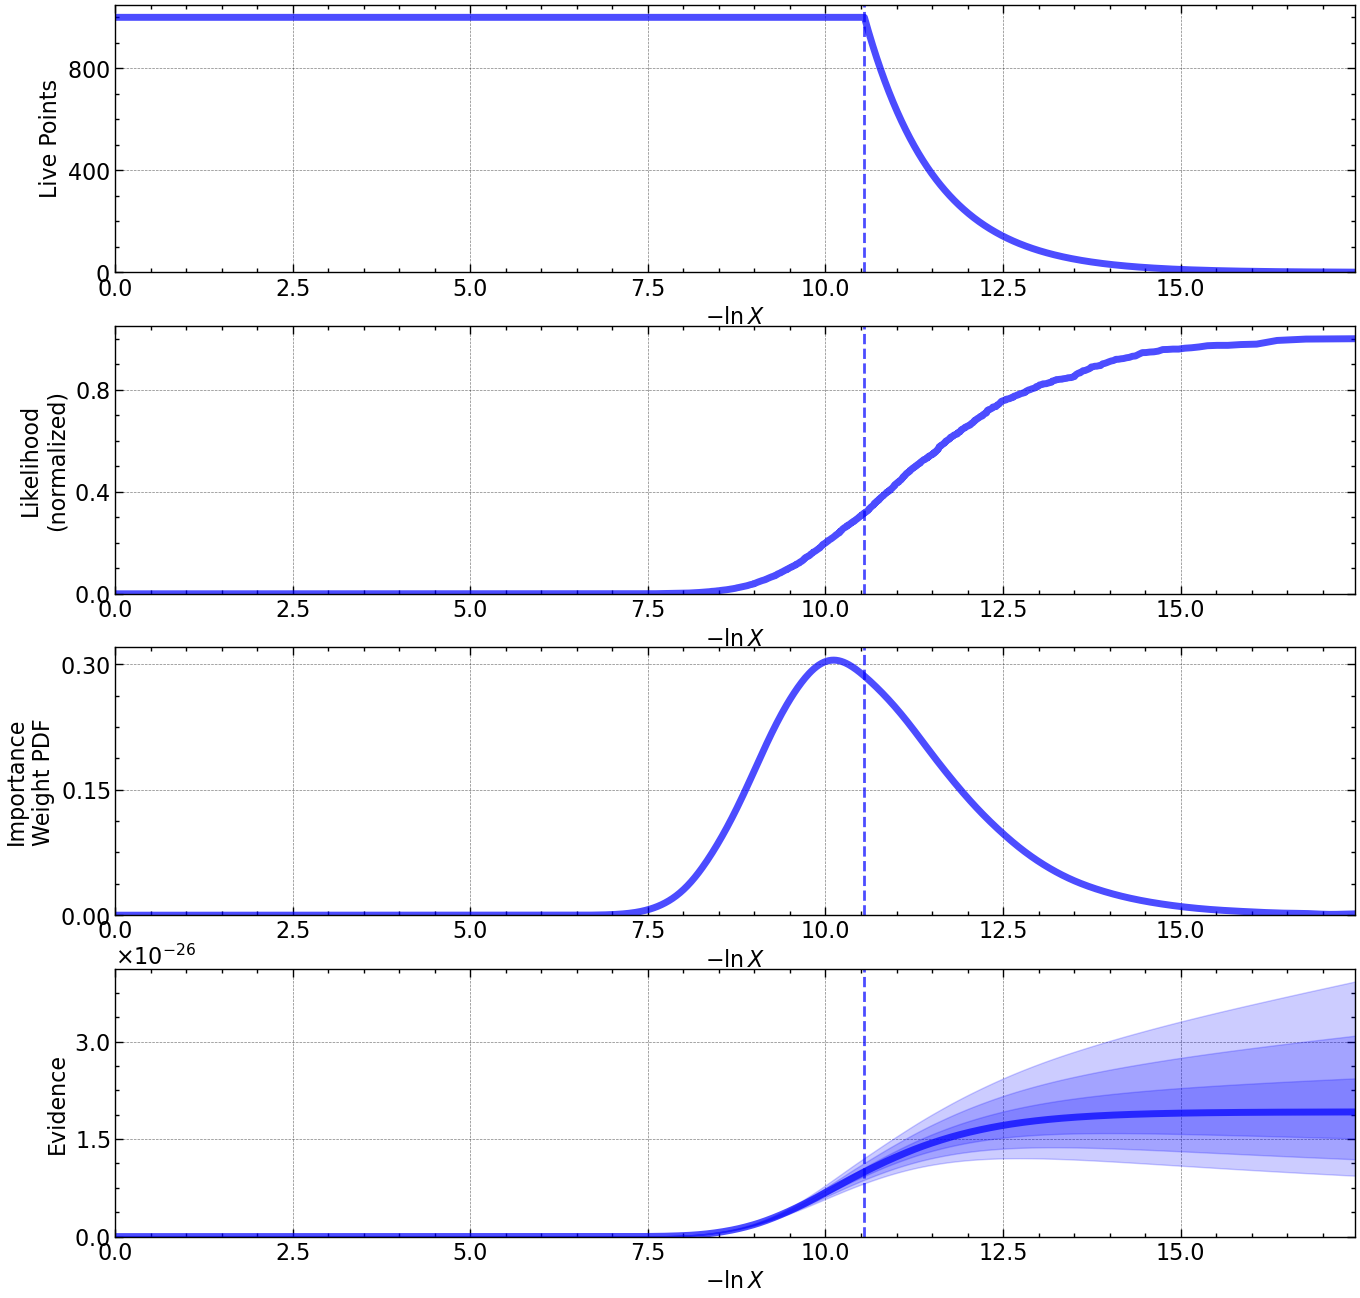

In [10]:
fig, axes = dyplot.runplot(results)

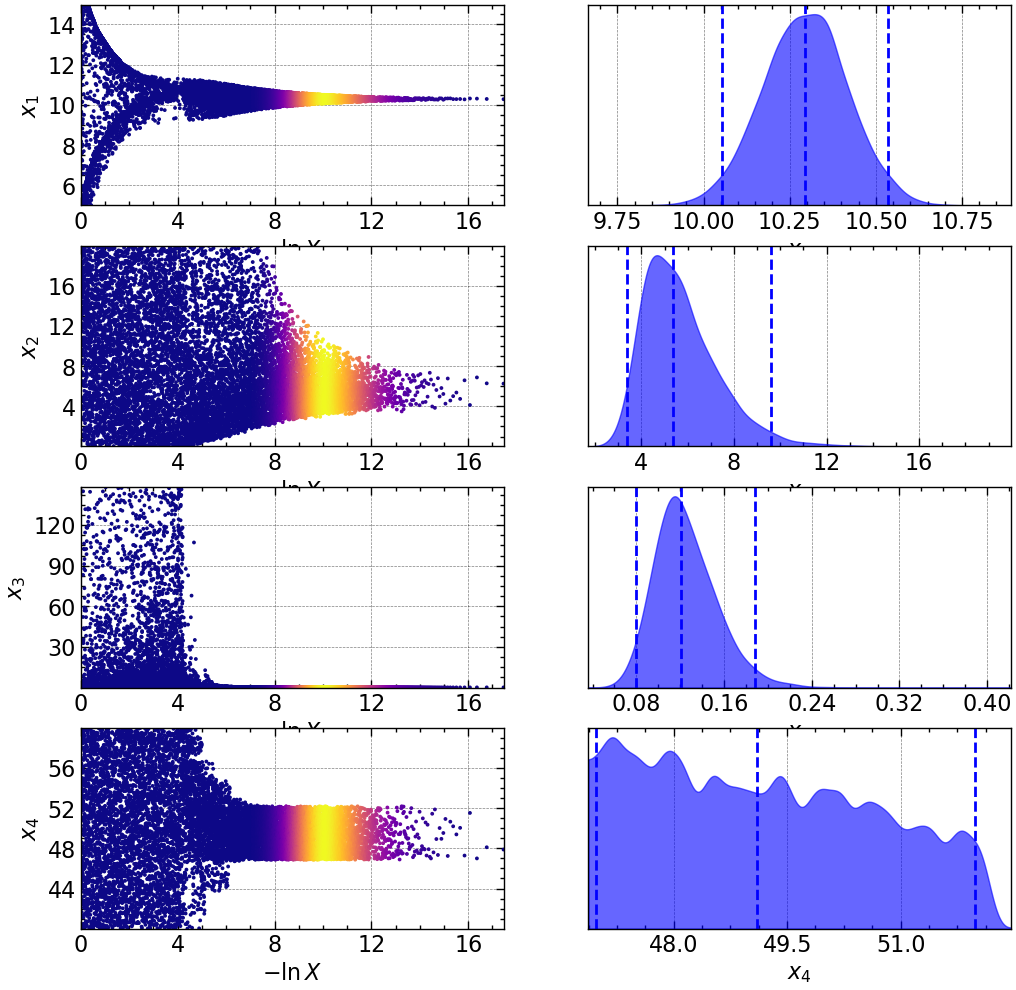

In [11]:
fig, axes = dyplot.traceplot(results)

## 5) Corner plot

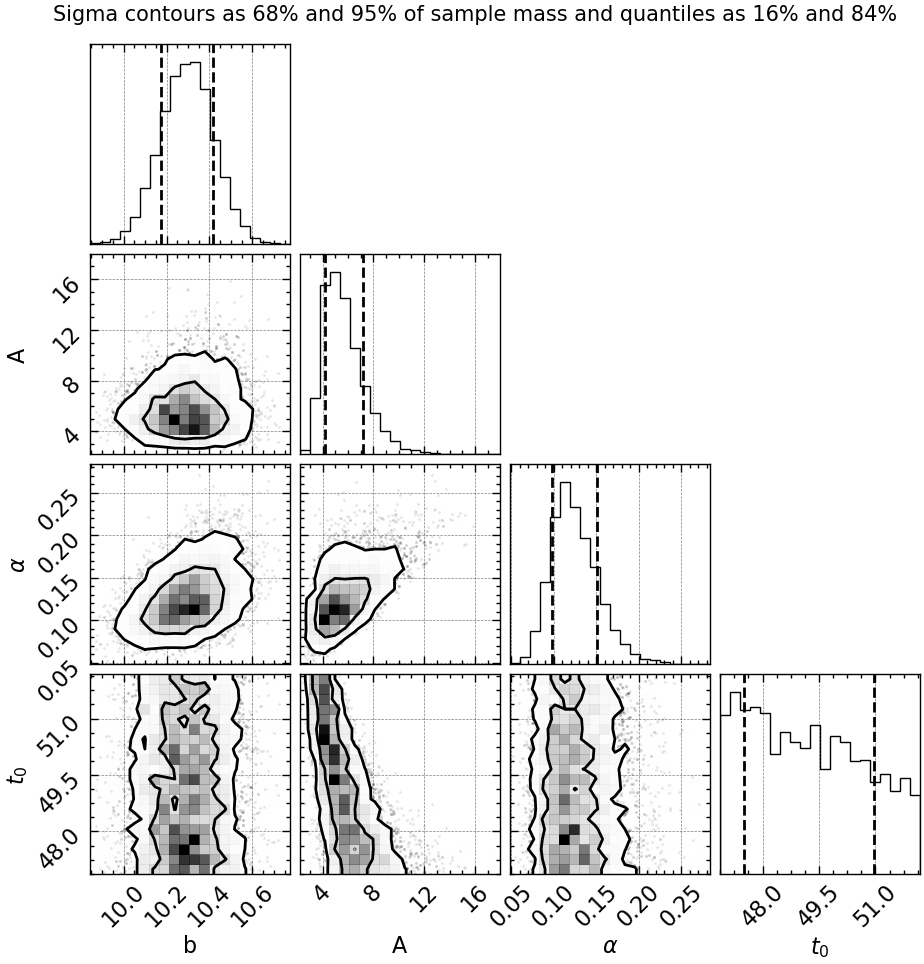

In [12]:
# Resample weighted samples.
samples = results.samples
weights = np.exp(results.logwt - results.logz[-1])
samples_equal = dyfunc.resample_equal(samples, weights)
fig = corner.corner(samples_equal, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['b','A','$\\alpha$', '$t_0$'])
fig.suptitle("Sigma contours as 68% and 95% of sample mass and quantiles as 16% and 84%", fontsize=15, y=1);

## 6) Time-series plot

In [13]:
chosen_samples = samples_equal[np.random.choice(len(samples_equal), size=100)]
chosen_samples.shape

(100, 4)

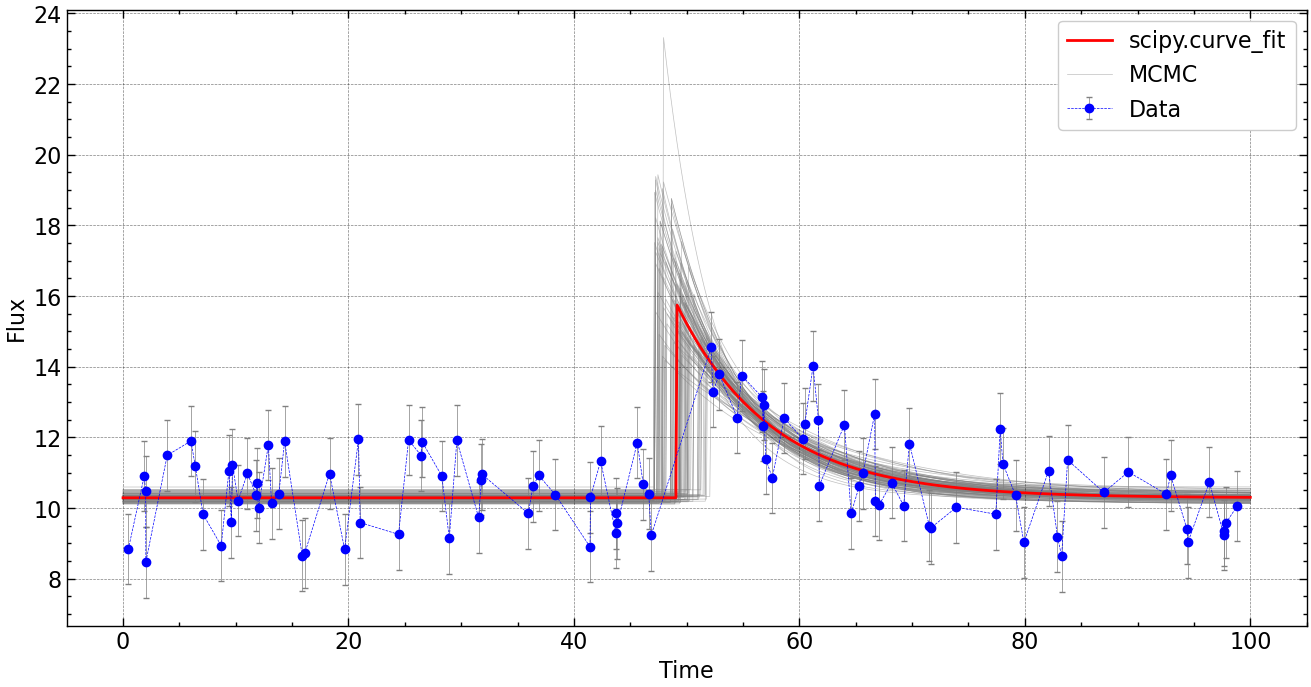

In [14]:
fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, lw=0.5, label='Data')
x_dense = np.linspace(0, 100, 1000)
plt.plot(x_dense, model_burst(x_dense, popt[0], popt[1], popt[2], popt[3]), color='red', label='scipy.curve_fit')
plt.xlabel('Time')
plt.ylabel('Flux')

for chosen_sample in chosen_samples:
    if np.array_equal(chosen_sample, chosen_samples[0]) : plt.plot(x_dense, model_burst(x_dense, chosen_sample[0], chosen_sample[1], chosen_sample[2], chosen_sample[3]), color='grey', lw=0.5, alpha=0.5, label='MCMC', zorder=0)
    plt.plot(x_dense, model_burst(x_dense, chosen_sample[0], chosen_sample[1], chosen_sample[2], chosen_sample[3]), color='grey', lw=0.5, alpha=0.5, zorder=0)
    
plt.legend()

## 7) Median and credible region of each parameter

In [15]:
statistics_b = dyfunc.quantile(samples[:,0], [0.05, 0.5, 0.95], weights=weights)
display(Latex(f'$\Large b = {statistics_b[1]:.2f}^{{+{statistics_b[2]-statistics_b[1]:.2f}}}_{{-{statistics_b[1]-statistics_b[0]:.2f}}}$'))

statistics_A = dyfunc.quantile(samples[:,1], [0.05, 0.5, 0.95], weights=weights)
display(Latex(f'$\Large A = {statistics_A[1]:.2f}^{{+{statistics_A[2]-statistics_A[1]:.2f}}}_{{-{statistics_A[1]-statistics_A[0]:.2f}}}$'))

statistics_alpha = dyfunc.quantile(samples[:,2], [0.05, 0.5, 0.95], weights=weights)
display(Latex(f'$\Large \\alpha = {statistics_alpha[1]:.2f}^{{+{statistics_alpha[2]-statistics_alpha[1]:.2f}}}_{{-{statistics_alpha[1]-statistics_alpha[0]:.2f}}}$'))

statistics_t0 = dyfunc.quantile(samples[:,3], [0.05, 0.5, 0.95], weights=weights)
display(Latex(f'$\Large t_0 = {statistics_t0[1]:.2f}^{{+{statistics_t0[2]-statistics_t0[1]:.2f}}}_{{-{statistics_t0[1]-statistics_t0[0]:.2f}}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## 8) Try to use a gaussian model

$f_{gaussian}(t \,|\, b, A, \sigma_W, t_0) = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

In [16]:
def model_gaussian(x, b, A, sigmaW, t0):
    return b + A*np.exp(-0.5*np.square((x-t0)/sigmaW))

In [17]:
b_min = 5
b_max = 15
A_min = 0
A_max = 10
sigmaW_min = np.exp(-3)
sigmaW_max = np.exp(3)
t0_min = 45
t0_max = 65

def ptform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)` to the parameters of interest."""

    theta = np.array(u)

    theta[0] = scipy.stats.uniform(loc=b_min, scale=b_max-b_min).ppf(u[0])
    theta[1] = scipy.stats.uniform(loc=A_min, scale=A_max-A_min).ppf(u[1])
    theta[2] = scipy.stats.loguniform.ppf(u[2], sigmaW_min, sigmaW_max)
    theta[3] = scipy.stats.uniform(loc=t0_min, scale=t0_max-t0_min).ppf(u[3])
  
    return theta

In [18]:
ndim = 4
sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim, 
                                logl_args=[data[:,0], data[:,1], data[:,2], model_gaussian],
                                nlive=1000)
sampler.run_nested()
results_gauss = sampler.results

10830it [01:50, 97.76it/s, +1000 | bound: 26 | nc: 1 | ncall: 73535 | eff(%): 16.309 | loglstar:   -inf < -52.481 <    inf | logz: -63.313 +/-  0.115 | dlogz:  0.001 >  1.009]


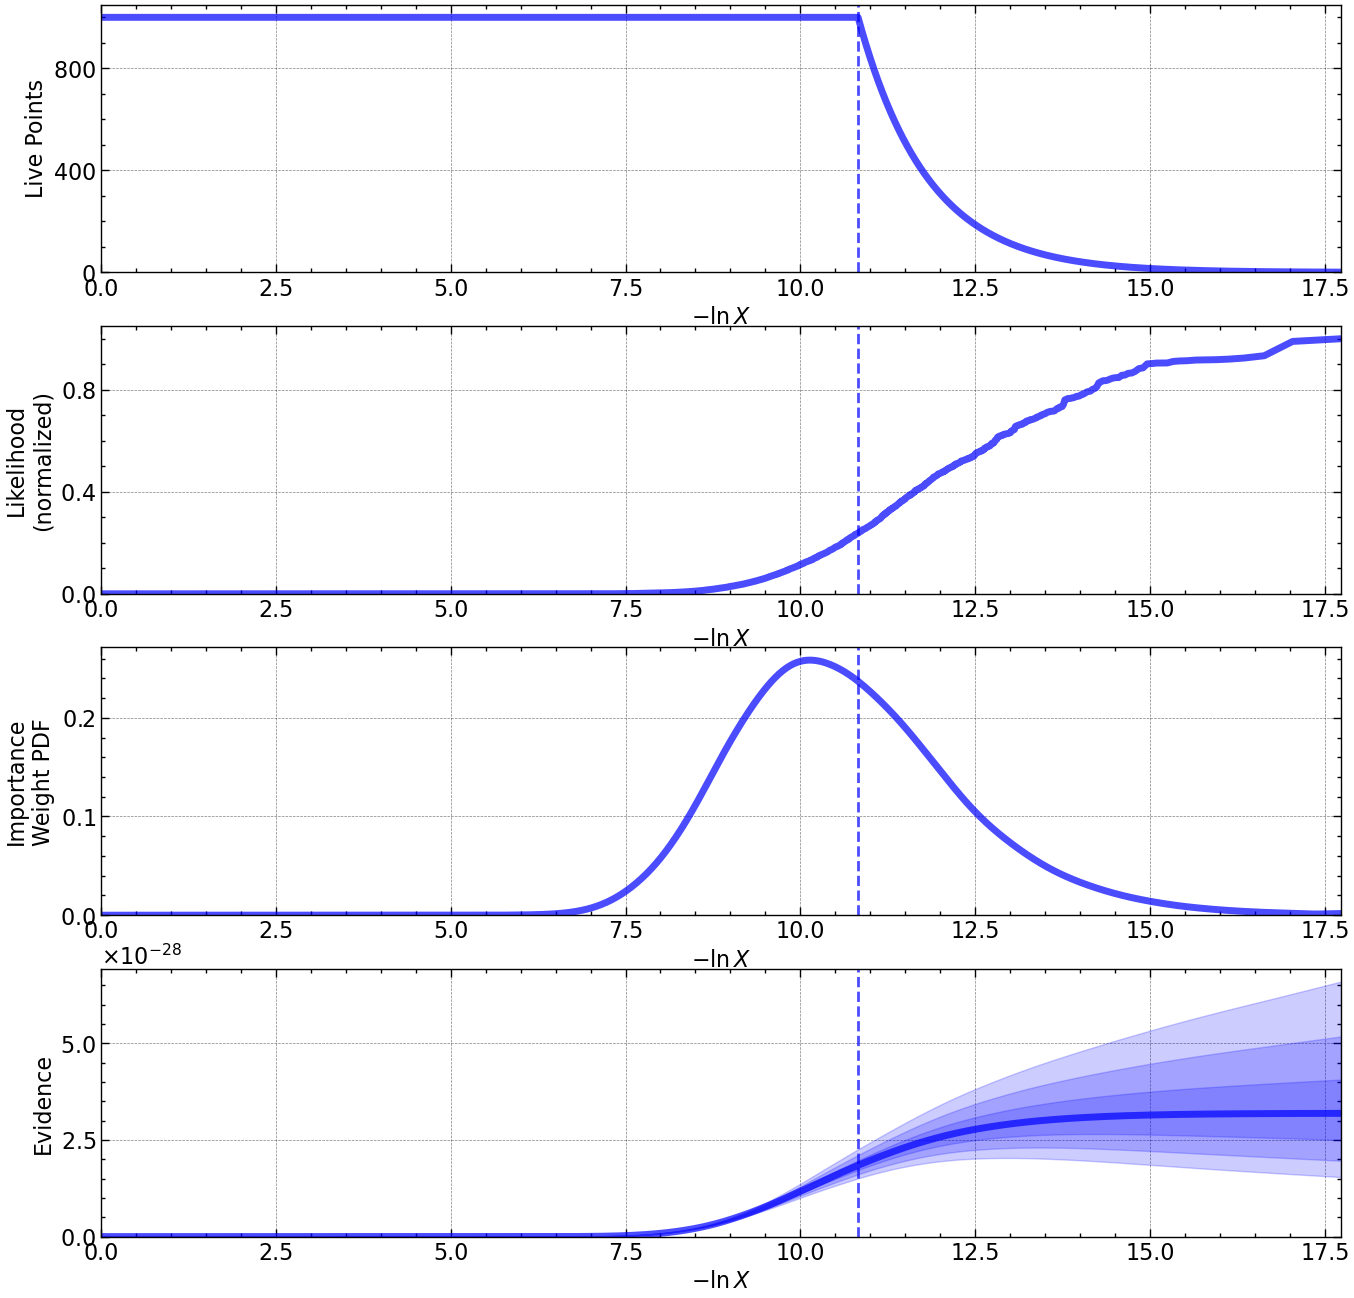

In [19]:
fig, axes = dyplot.runplot(results_gauss)

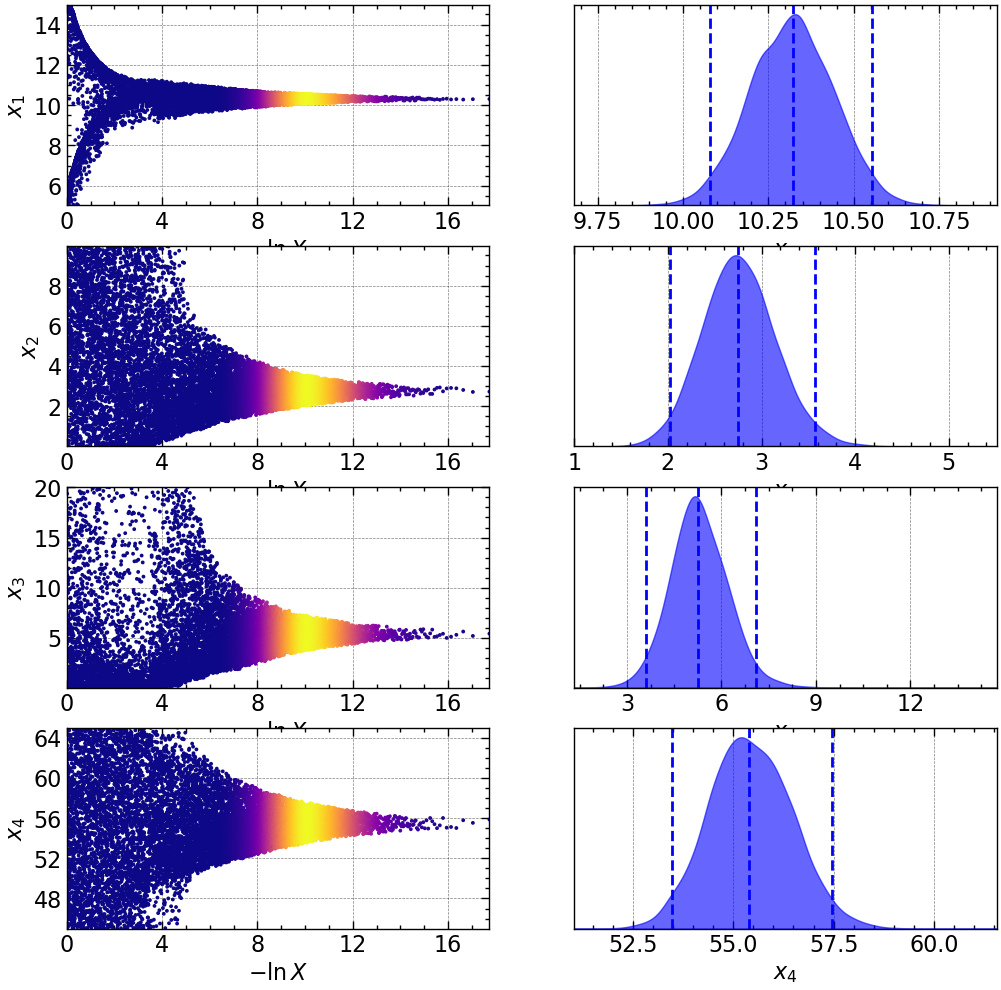

In [20]:
fig, axes = dyplot.traceplot(results_gauss)

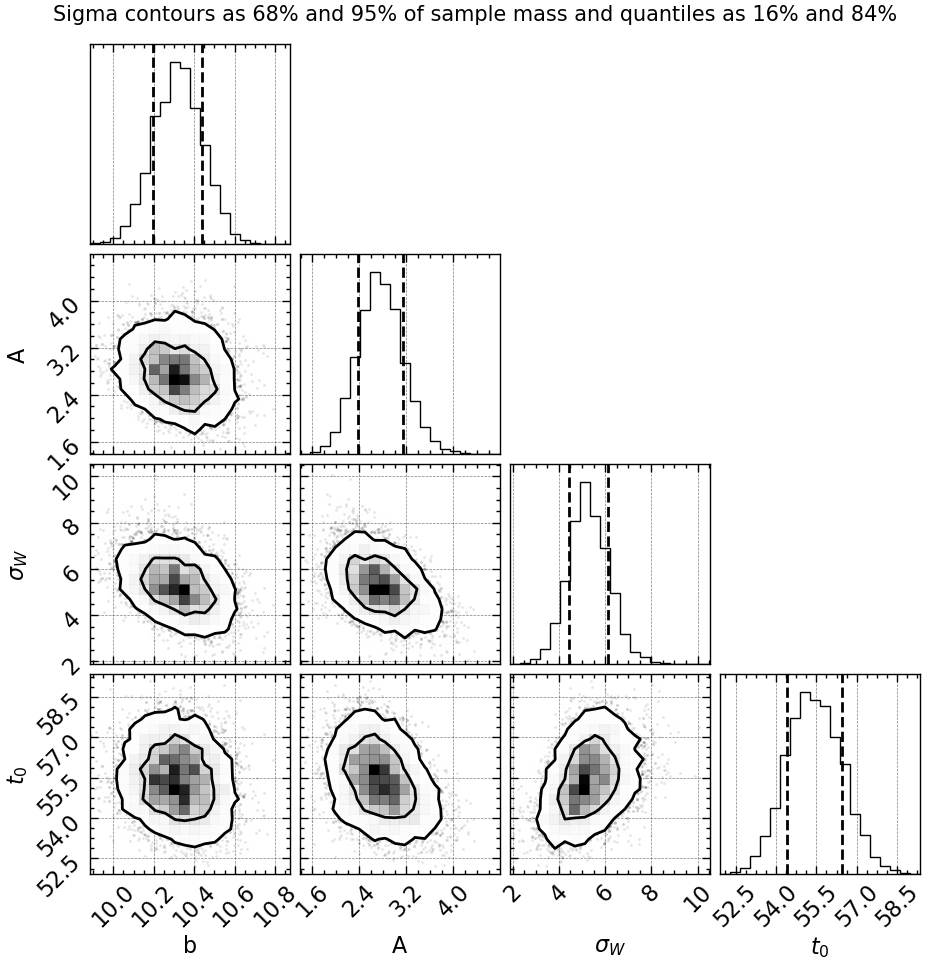

In [21]:
# Resample weighted samples.
samples = results_gauss.samples
weights = np.exp(results_gauss.logwt - results_gauss.logz[-1])
samples_equal = dyfunc.resample_equal(samples, weights)
fig = corner.corner(samples_equal, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['b','A','$\\sigma_W$', '$t_0$'])
fig.suptitle("Sigma contours as 68% and 95% of sample mass and quantiles as 16% and 84%", fontsize=15, y=1);

In [22]:
chosen_samples = samples_equal[np.random.choice(len(samples_equal), size=100)]
chosen_samples.shape

(100, 4)

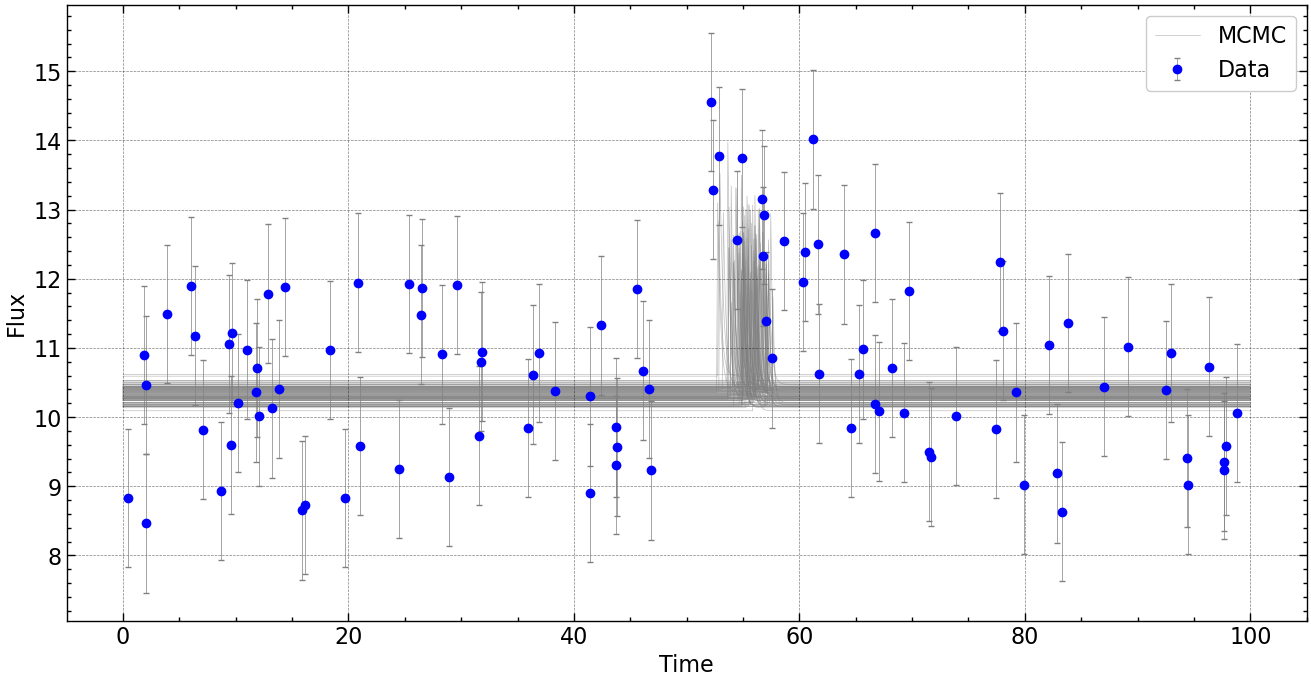

In [23]:
fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, lw=0.5, label='Data')
x_dense = np.linspace(0, 100, 1000)
plt.xlabel('Time')
plt.ylabel('Flux')

for chosen_sample in chosen_samples:
    if np.array_equal(chosen_sample, chosen_samples[0]) : plt.plot(x_dense, model_burst(x_dense, chosen_sample[0], chosen_sample[1], chosen_sample[2], chosen_sample[3]), color='grey', lw=0.5, alpha=0.5, label='MCMC', zorder=0)
    plt.plot(x_dense, model_burst(x_dense, chosen_sample[0], chosen_sample[1], chosen_sample[2], chosen_sample[3]), color='grey', lw=0.5, alpha=0.5, zorder=0)
    
plt.legend()

In [24]:
statistics_b = dyfunc.quantile(samples[:,0], [0.05, 0.5, 0.95], weights=weights)
display(Latex(f'$\Large b = {statistics_b[1]:.2f}^{{+{statistics_b[2]-statistics_b[1]:.2f}}}_{{-{statistics_b[1]-statistics_b[0]:.2f}}}$'))

statistics_A = dyfunc.quantile(samples[:,1], [0.05, 0.5, 0.95], weights=weights)
display(Latex(f'$\Large A = {statistics_A[1]:.2f}^{{+{statistics_A[2]-statistics_A[1]:.2f}}}_{{-{statistics_A[1]-statistics_A[0]:.2f}}}$'))

statistics_sigmaW = dyfunc.quantile(samples[:,2], [0.05, 0.5, 0.95], weights=weights)
display(Latex(f'$\Large \\sigma_W = {statistics_sigmaW[1]:.2f}^{{+{statistics_sigmaW[2]-statistics_sigmaW[1]:.2f}}}_{{-{statistics_sigmaW[1]-statistics_sigmaW[0]:.2f}}}$'))

statistics_t0 = dyfunc.quantile(samples[:,3], [0.05, 0.5, 0.95], weights=weights)
display(Latex(f'$\Large t_0 = {statistics_t0[1]:.2f}^{{+{statistics_t0[2]-statistics_t0[1]:.2f}}}_{{-{statistics_t0[1]-statistics_t0[0]:.2f}}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## 9) Model selection

In [25]:
evidence_burst = np.exp(results.logz[-1])
evidence_burst

1.9171229343877685e-26

In [26]:
evidence_gauss = np.exp(results_gauss.logz[-1])
evidence_gauss

3.1879502039050605e-28

In [27]:
odds_ratio = evidence_burst/evidence_gauss
display(Latex(f'$\Large OR = \dfrac{{Z_{{burst}}}}{{Z_{{gauss}}}} = {odds_ratio:.1f}$'))

<IPython.core.display.Latex object>

In terms of *Jeffrey's scale*, there is *very strong* evidence in favor of the burst model.